<a href="https://colab.research.google.com/github/AkiraMJ/-MEC-502_Topicos_MecSol-/blob/main/Atividade_3_3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Placa Estática 2D Exercício 3a

*
Implemente em PyTorch uma PINN para encontrar os deslocamentos nas direções x e y para o problema da placa bidimensional.

*Engaste nos lados esquerdo e inferior

* σxx(L, y) = 1 e σxy = 0 em todo o contorno.



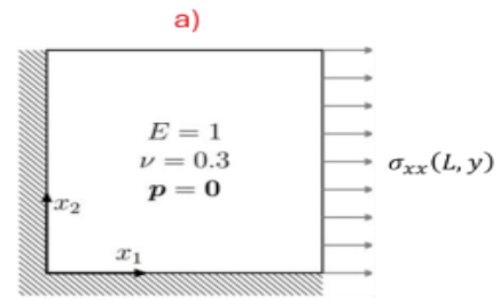

In [ ]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1-u_xoohp-Ycnzb_YZGuxH8uL3RNOZUaj'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (500, 300)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/1-u_xoohp-Ycnzb_YZGuxH8uL3RNOZUaj/view?usp=drive_link

**bibliotecas importantes**

In [ ]:
# import numpy as np
# import torch
# from torch.autograd import grad
# import time
# import matplotlib.pyplot as plt

## Definições Iniciais

**cálculo de gradientes com diferenciação automática**

In [ ]:
# def getDerivative(y, x, n):
#     if n == 0:
#         return y
#     else:
#         dy_dx = grad(y, x, torch.ones(x.shape), create_graph=True, retain_graph=True)[0]
#         return getDerivative(dy_dx, x, n - 1)

**rede neural**  
Aqui é utilizado um formato ainda mais geral do que no caso do problema unidimensional, mas segue a mesma lógica:

* Definir a função construtora `__init__`
* Gerar a construção automática da rede de acordo com a quantidade de camadas ocultas e número de neurônios
* A função de ativação **Tangente Hiperbólica** é definida como padrão
* Os demais comandos como `nn.Linear` e `nn.Sequential`foram explicados no outro notebook

In [ ]:
# class NN(torch.nn.Module):
#     def __init__(self, inputDimension, hiddenDimensions, outputDimension, activationFunction=torch.nn.Tanh()):
#         super().__init__()
#         modules = []
#         modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
#         modules.append(activationFunction)
#         for i in range(len(hiddenDimensions) - 1):
#             modules.append(torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1]))
#             modules.append(activationFunction)
#         modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))
#         self.model = torch.nn.Sequential(*modules)

#     def forward(self, x):
#         return self.model(x)

**Criação de um grid**

Como nosso problema é bidimensional, precisamos criar um grid de pontos, nas direções x e y.  
Assim é definida uma função **`getGrid`** que recebe as dimensões de cada lado do quadrado $(L_x, L_y)$ e número de pontos na direção x e y $(N_x, N_y)$

**Tome nota** `torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)` concatena as matrizes x e y achatadas (flattened) em uma única matriz de tamanho $(N_x \times N_y, 2)$ onde cada linha é um par $(x_i, y_i)$



In [ ]:
# def getGrid(Lx, Ly, Nx, Ny):
#     x = torch.linspace(0, Lx, Nx)
#     y = torch.linspace(0, Ly, Ny)
#     x, y = torch.meshgrid(x, y, indexing="ij")
#     x.requires_grad = True
#     y.requires_grad = True
#     input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
#     return x, y, input

**condição de contorno de Dirichlet na forma forte**

Para forçar que não haja deslocamento nas direções $u_y(x,0)$ e $u_x(0,y)$ é possível adotar a estratégia de definir o contorno de maneira **FORTE**, isto é, impondo no deslocamento funções que dependendam das coordenadas.

In [ ]:
# # --- Engaste forte em x=0 e y=0 ---
# strongEnforcementx = lambda u_x, x, y: x * y * u_x
# strongEnforcementy = lambda u_y, x, y: x * y * u_y

**Parametros Físicos**

Da Lei de Hooke em 2D, temos que a matriz de coeficientes materiais é expressa por:

$$C = \frac{E}{1-\nu^2} \begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & 1 - \nu
\end{bmatrix}
$$


In [ ]:
# # Dados do Problema
# Lx = 1      # Comprimento em x
# Ly = 1      # Comprimento em y
# E = 1.0     # Modulo de Elasticidade
# nu = 0.3    # Coeficiente de Poisson

# C = torch.zeros((3, 3))
# C[0, 0] = 1
# C[0, 1] = nu
# C[1, 0] = nu
# C[1, 1] = 1
# C[2, 2] = 1 - nu
# C *= E / (1 - nu**2)


## Funções para criar a PINN

**calculo do deslocamento**
$$\hat{\boldsymbol{u}}=(\hat{u},\hat{v})^\intercal=F_{NN}(x)$$

os deslocamentos que queremos calcular são resultados da rede.

O método **`.unsqueeze(1)`** no PyTorch (ou em bibliotecas baseadas nele, como o SciANN) adiciona uma dimensão extra ao tensor na posição especificada (**no caso, 1,** que é a segunda dimensão).

Isso é útil para garantir que o tensor tenha a forma (shape) correta para operações subsequentes.

In [ ]:
# def getDisplacements(model, input, strongEnforcementx, strongEnforcementy):
#     u = model(input)
#     ux = strongEnforcementx(u[:, 0], input[:, 0], input[:, 1]).unsqueeze(1)
#     uy = strongEnforcementy(u[:, 1], input[:, 0], input[:, 1]).unsqueeze(1)
#     u = torch.cat((ux, uy), 1)
#     return u  # model(x)

**cálculo das deformações**

Da teoria da elasticidade linear, podemos calcular as deformações $\varepsilon_x, \varepsilon_y$ e $\varepsilon_{xy}$ seguindo o equacionamento a seguir

$$\boldsymbol{\varepsilon}=\begin{pmatrix}
\frac{\partial u}{\partial x}\\
\frac{\partial v}{\partial y}\\
\frac{1}{2}(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x})
\end{pmatrix}
$$

vamos definir uma função **`getStrains`** que deve receber: $u, x, y, N_x, N_y$ e retornar as três deformações

In [ ]:
# def getStrains(u, x, y, Nx, Ny):
#     strain = torch.zeros((3, Nx, Ny))
#     strain[0] = getDerivative(u[:, 0].reshape(Nx, Ny), x, 1)
#     strain[1] = getDerivative(u[:, 1].reshape(Nx, Ny), y, 1)
#     strain[2] = 0.5 * (
#         getDerivative(u[:, 0].reshape(Nx, Ny), y, 1)
#         + getDerivative(u[:, 1].reshape(Nx, Ny), x, 1)
#     )
#     return strain

**calculo das funcões de perda**

**tensão** $$\boldsymbol{\sigma}=\boldsymbol{C}\boldsymbol{\varepsilon}$$

**residuo** $$\boldsymbol{r}=\nabla \cdot \boldsymbol{\sigma} + \boldsymbol{p}$$

como no caso $\boldsymbol{p} = 0$ a equação anterior pode ser expressa como:

$$\boldsymbol{r}= \begin{bmatrix}
\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_{2}} \\
\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_{2}}
\end{bmatrix}$$

**perda residual** $$\mathcal{L}_R = \frac{1}{N}\sum_i^N \sum_j^2 (\hat{\boldsymbol{r}}_j)^2$$

perda do contorno (necessária apenas para a condição de contorno de Neumann quando a forma forte é usada na condição de Dirichlet)

$$\mathcal{L}_B=\frac{1}{N_{11}}\sum_i^{N_{11}} (\hat{\sigma}_{11}-\tilde{\sigma}_{11})^2 + \frac{1}{N_{22}}\sum_i^{N_{22}} (\hat{\sigma}_{22}-\tilde{\sigma}_{22})^2 + \frac{1}{N_{12}}\sum_i^{N_{12}} (\hat{\sigma}_{12}-\tilde{\sigma}_{12})^2$$

Pelo cenário definido, tem-se:
$$
\begin{aligned}
\sigma_{22}(x_1,L) &= 0 \hspace{1cm} \sigma_{11}(L,x_2) = t \\
\sigma_{12}(x_1,0) &= 0 \hspace{1cm} \sigma_{12}(0,x_2) = 0 \hspace{1cm} \sigma_{12}(x_1,L) = 0 \hspace{1cm} \sigma_{12}(L,x_2) = 0   
\end{aligned}
$$


In [ ]:
# def getLossTerms(x, y, u, Nx, Ny, C):
#     strain = getStrains(u, x, y, Nx, Ny)
#     stress = torch.tensordot(C, strain, dims=1)

#     # Equilíbrio
#     dsig11_dx = getDerivative(stress[0], x, 1)
#     dsig12_dy = getDerivative(stress[2], y, 1)
#     dsig21_dx = getDerivative(stress[2], x, 1)
#     dsig22_dy = getDerivative(stress[1], y, 1)

#     EDP_Loss = 0
#     EDP_Loss += torch.sum((dsig11_dx + dsig12_dy) ** 2) / (Nx * Ny)
#     EDP_Loss += torch.sum((dsig21_dx + dsig22_dy) ** 2) / (Nx * Ny)

#     # Condições de contorno
#     BC_Loss = 0
#     traction = 1  # σ_xx(L, y) = 1

#     # σ_xx na face direita
#     BC_Loss += torch.sum((stress[0][-1, :] - traction) ** 2) / Ny

#     # σ_xy = 0 em todo o contorno
#     BC_Loss += torch.sum((stress[2][0, :] - 0) ** 2) / Ny      # esquerda
#     BC_Loss += torch.sum((stress[2][-1, :] - 0) ** 2) / Ny     # direita
#     BC_Loss += torch.sum((stress[2][:, 0] - 0) ** 2) / Nx      # inferior
#     BC_Loss += torch.sum((stress[2][:, -1] - 0) ** 2) / Nx     # superior

#     return EDP_Loss, BC_Loss

## Estrutura do Problema

**hiperparametros**

* Haverá 100 pontos de colocação (10 x 10)
* A rede terá **3 camadas escondidas** com **20 neurônios**
* A função de ativação será a **Tangente Hiperbólica (ou SiLU)**
* Será utilizado o **otimizador Adam**.
* Serão 501 épocas, com taxa de aprendizagem de 0.01

**Tome nota:** **`weightLrFactor`** Esse parâmetro controla um fator de multiplicação aplicado à taxa de aprendizado (learning rate) para os pesos da rede neural (não confundir com a taxa de aprendizado global).



In [ ]:
Nx = 10  # number of collocation points in x
Ny = 10  # number of collocation points in y
hiddenDimensions = [20, 20, 20]
activationFunction = torch.nn.SiLU()

epochs = 501  # number of epochs
lr = 1e-2  # learning rate
weightLrFactor = 1e1
selectOptimizer = "Adam"

**rede e otimizador**

In [ ]:
# model = NN(2, hiddenDimensions, 2, activationFunction)
# optimizer = torch.optim.Adam(model.parameters(), lr)

# weights = torch.ones(2)
# weights.requires_grad = True
# optimizer.add_param_group({"params": weights})
# optimizer.param_groups[-1]["lr"] = lr * weightLrFactor

**pontos do treinamento**

In [ ]:
x, y, input = getGrid(Lx, Ly, Nx, Ny)

## Treinamento

**funcao custo / perda total**

A função custo é a soma da loss da PDE e das BCs
$$C=\kappa_R\mathcal{L}_R + \kappa_B\mathcal{L}_B$$

In [ ]:
# EDP_LossHistory = np.zeros(epochs)
# BC_LossHistory = np.zeros(epochs)
# costHistory = np.zeros(epochs)
# start = time.perf_counter()
# start0 = start

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     uPred = getDisplacements(model, input, strongEnforcementx, strongEnforcementy)
#     lossTerms = getLossTerms(x, y, uPred, Nx, Ny, C)
#     cost = weights[0] * lossTerms[0] + weights[1] * lossTerms[1]
#     cost.backward()
#     weights.grad *= -1
#     optimizer.step()

#     EDP_LossHistory[epoch] = lossTerms[0].detach()
#     BC_LossHistory[epoch] = lossTerms[1].detach()
#     costHistory[epoch] = lossTerms[0].detach() + lossTerms[1].detach()

#     if epoch % 50 == 0:
#         elapsedTime = (time.perf_counter() - start) / 50
#         print(f"Epoch: {epoch}/{epochs}\tDE cost = {EDP_LossHistory[epoch]:.2e}\tBC cost = {BC_LossHistory[epoch]:.2e}\tTotal cost = {costHistory[epoch]:.2e}\tElapsed time = {elapsedTime:2f}")
#         start = time.perf_counter()

# elapsedTime = time.perf_counter() - start0
# print(f"Total elapsed time: {elapsedTime:2f}\nAverage elapsed time per epoch: {elapsedTime/epochs:2f}")


## Pos-processamento

**predicao dos deslocamentos**

In [ ]:
# # Pós-processamento
# Nx_ = 100
# Ny_ = 100
# x_, y_, input_ = getGrid(Lx, Ly, Nx_, Ny_)
# upred = getDisplacements(model, input_, strongEnforcementx, strongEnforcementy)

# xx = x_.detach()
# yy = y_.detach()
# u_x = upred[:, 0].reshape(Nx_, Ny_).detach()
# u_y = upred[:, 1].reshape(Nx_, Ny_).detach()

# fig, ax = plt.subplots()
# cp = ax.pcolormesh(xx, yy, u_x, cmap=plt.cm.jet, shading='auto')
# fig.colorbar(cp)
# ax.plot(x.detach(), y.detach(), "k.")
# plt.gca().set_aspect("equal", adjustable="box")
# ax.set_title("$u_x$")
# plt.show()

# fig, ax = plt.subplots()
# cp = ax.pcolormesh(xx, yy, u_y, cmap=plt.cm.jet, shading='auto')
# fig.colorbar(cp)
# ax.plot(x.detach(), y.detach(), "k.")
# plt.gca().set_aspect("equal", adjustable="box")
# ax.set_title("$u_y$")
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(costHistory, "k", label="Total")
# ax.plot(EDP_LossHistory, "r:", label="DE loss")
# ax.plot(BC_LossHistory, "b:", label="BC loss")
# ax.set_yscale("log")
# ax.grid()
# ax.legend()
# plt.show()

##CÓDIGO COMPLETO

Epoch: 0/10000	DE cost = 3.31e-03	BC cost = 9.97e-01	Total cost = 1.00e+00	Elapsed time = 0.002562
Epoch: 50/10000	DE cost = 4.13e-02	BC cost = 3.33e-01	Total cost = 3.75e-01	Elapsed time = 0.070166
Epoch: 100/10000	DE cost = 5.31e-02	BC cost = 3.00e-01	Total cost = 3.53e-01	Elapsed time = 0.055187
Epoch: 150/10000	DE cost = 5.63e-02	BC cost = 2.69e-01	Total cost = 3.25e-01	Elapsed time = 0.054158
Epoch: 200/10000	DE cost = 6.18e-02	BC cost = 2.55e-01	Total cost = 3.17e-01	Elapsed time = 0.054882
Epoch: 250/10000	DE cost = 5.96e-02	BC cost = 2.59e-01	Total cost = 3.19e-01	Elapsed time = 0.064640
Epoch: 300/10000	DE cost = 5.98e-02	BC cost = 2.43e-01	Total cost = 3.03e-01	Elapsed time = 0.059718
Epoch: 350/10000	DE cost = 5.45e-02	BC cost = 2.39e-01	Total cost = 2.93e-01	Elapsed time = 0.054400
Epoch: 400/10000	DE cost = 4.99e-02	BC cost = 2.45e-01	Total cost = 2.95e-01	Elapsed time = 0.054105
Epoch: 450/10000	DE cost = 4.91e-02	BC cost = 2.69e-01	Total cost = 3.18e-01	Elapsed time = 0.

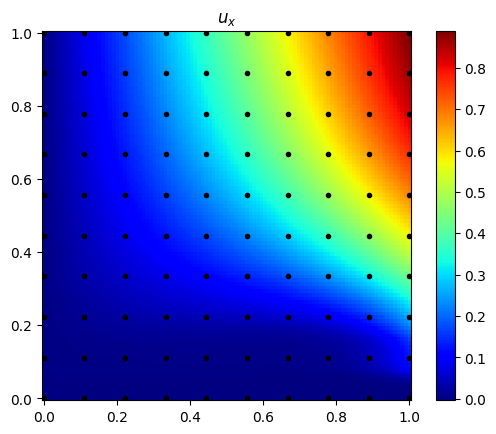

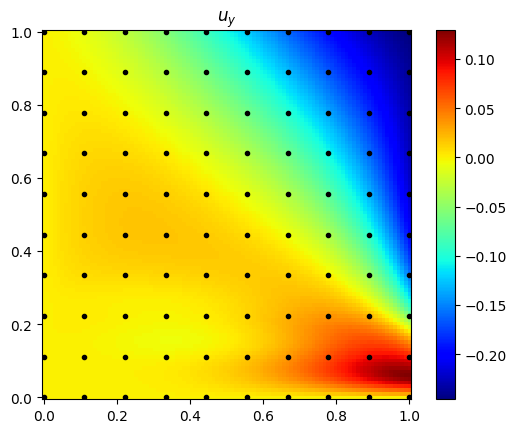

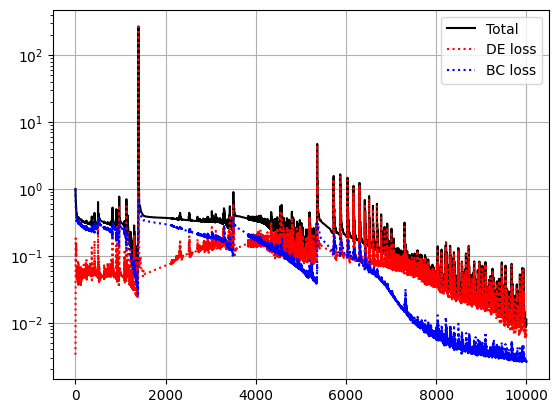

In [ ]:
import numpy as np
import torch
from torch.autograd import grad
import time
import matplotlib.pyplot as plt

def getDerivative(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.shape), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

class NN(torch.nn.Module):
    def __init__(self, inputDimension, hiddenDimensions, outputDimension, activationFunction=torch.nn.Tanh()):
        super().__init__()
        modules = []
        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1]))
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))
        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

def getGrid(Lx, Ly, Nx, Ny):
    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    x, y = torch.meshgrid(x, y, indexing="ij")
    x.requires_grad = True
    y.requires_grad = True
    input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
    return x, y, input

# --- Engaste forte em x=0 e y=0 ---
strongEnforcementx = lambda u_x, x, y: x * y * u_x
strongEnforcementy = lambda u_y, x, y: x * y * u_y

# Dados do problema
Lx = 1
Ly = 1
E = 1.0
nu = 0.3

C = torch.zeros((3, 3))
C[0, 0] = 1
C[0, 1] = nu
C[1, 0] = nu
C[1, 1] = 1
C[2, 2] = 1 - nu
C *= E / (1 - nu**2)

def getDisplacements(model, input, strongEnforcementx, strongEnforcementy):
    u = model(input)
    ux = strongEnforcementx(u[:, 0], input[:, 0], input[:, 1]).unsqueeze(1)
    uy = strongEnforcementy(u[:, 1], input[:, 0], input[:, 1]).unsqueeze(1)
    return torch.cat((ux, uy), 1)

def getStrains(u, x, y, Nx, Ny):
    strain = torch.zeros((3, Nx, Ny))
    strain[0] = getDerivative(u[:, 0].reshape(Nx, Ny), x, 1)
    strain[1] = getDerivative(u[:, 1].reshape(Nx, Ny), y, 1)
    strain[2] = 0.5 * (
        getDerivative(u[:, 0].reshape(Nx, Ny), y, 1) +
        getDerivative(u[:, 1].reshape(Nx, Ny), x, 1)
    )
    return strain

def getLossTerms(x, y, u, Nx, Ny, C):
    strain = getStrains(u, x, y, Nx, Ny)
    stress = torch.tensordot(C, strain, dims=1)

    # Equilíbrio
    dsig11_dx = getDerivative(stress[0], x, 1)
    dsig12_dy = getDerivative(stress[2], y, 1)
    dsig21_dx = getDerivative(stress[2], x, 1)
    dsig22_dy = getDerivative(stress[1], y, 1)

    EDP_Loss = 0
    EDP_Loss += torch.sum((dsig11_dx + dsig12_dy) ** 2) / (Nx * Ny)
    EDP_Loss += torch.sum((dsig21_dx + dsig22_dy) ** 2) / (Nx * Ny)

    # Condições de contorno
    BC_Loss = 0
    traction = 1  # σ_xx(L, y) = 1

    # σ_xx na face direita
    BC_Loss += torch.sum((stress[0][-1, :] - traction) ** 2) / Ny

    # σ_xy = 0 em todo o contorno
    BC_Loss += torch.sum((stress[2][0, :] - 0) ** 2) / Ny      # esquerda
    BC_Loss += torch.sum((stress[2][-1, :] - 0) ** 2) / Ny     # direita
    BC_Loss += torch.sum((stress[2][:, 0] - 0) ** 2) / Nx      # inferior
    BC_Loss += torch.sum((stress[2][:, -1] - 0) ** 2) / Nx     # superior

    return EDP_Loss, BC_Loss

# Parâmetros de treino
Nx = 10
Ny = 10
hiddenDimensions = [20,20,20,20]
activationFunction = torch.nn.SiLU()
#activationFunction = torch.nn.Tanh()
epochs = 10000
lr = 1e-2
weightLrFactor = 1e1

model = NN(2, hiddenDimensions, 2, activationFunction)
optimizer = torch.optim.Adam(model.parameters(), lr)

weights = torch.ones(2)
weights.requires_grad = True
optimizer.add_param_group({"params": weights})
optimizer.param_groups[-1]["lr"] = lr * weightLrFactor

x, y, input = getGrid(Lx, Ly, Nx, Ny)

EDP_LossHistory = np.zeros(epochs)
BC_LossHistory = np.zeros(epochs)
costHistory = np.zeros(epochs)
start = time.perf_counter()
start0 = start

for epoch in range(epochs):
    optimizer.zero_grad()
    uPred = getDisplacements(model, input, strongEnforcementx, strongEnforcementy)
    lossTerms = getLossTerms(x, y, uPred, Nx, Ny, C)
    cost = weights[0] * lossTerms[0] + weights[1] * lossTerms[1]
    cost.backward()
    weights.grad *= -1
    optimizer.step()

    EDP_LossHistory[epoch] = lossTerms[0].detach()
    BC_LossHistory[epoch] = lossTerms[1].detach()
    costHistory[epoch] = lossTerms[0].detach() + lossTerms[1].detach()

    if epoch % 50 == 0:
        elapsedTime = (time.perf_counter() - start) / 50
        print(f"Epoch: {epoch}/{epochs}\tDE cost = {EDP_LossHistory[epoch]:.2e}\tBC cost = {BC_LossHistory[epoch]:.2e}\tTotal cost = {costHistory[epoch]:.2e}\tElapsed time = {elapsedTime:2f}")
        start = time.perf_counter()

elapsedTime = time.perf_counter() - start0
print(f"Total elapsed time: {elapsedTime:2f}\nAverage elapsed time per epoch: {elapsedTime/epochs:2f}")

# Pós-processamento
Nx_ = 100
Ny_ = 100
x_, y_, input_ = getGrid(Lx, Ly, Nx_, Ny_)
upred = getDisplacements(model, input_, strongEnforcementx, strongEnforcementy)

xx = x_.detach()
yy = y_.detach()
u_x = upred[:, 0].reshape(Nx_, Ny_).detach()
u_y = upred[:, 1].reshape(Nx_, Ny_).detach()

fig, ax = plt.subplots()
cp = ax.pcolormesh(xx, yy, u_x, cmap=plt.cm.jet, shading='auto')
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u_x$")
plt.show()

fig, ax = plt.subplots()
cp = ax.pcolormesh(xx, yy, u_y, cmap=plt.cm.jet, shading='auto')
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u_y$")
plt.show()

fig, ax = plt.subplots()
ax.plot(costHistory, "k", label="Total")
ax.plot(EDP_LossHistory, "r:", label="DE loss")
ax.plot(BC_LossHistory, "b:", label="BC loss")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()


* A estrutura da rede utilizada (número de camadas e neurônios);

* Quantidade de pontos de colocação - 100 (10x10)
* Função de ativação -SiLU
* Otimizador - Adam
* número de épocas - 10000
* taxa de aprendizagem - lr=0.01

* Destaque como as condições de deslocamentos foram definidas (soft ou hard)

-Condições de Deslocamento (Hard): Impostas por *strongEnforcement* que modifica a saída da rede. Isso garante que os deslocamentos são zero em x=0 e y=0 por construção.

-Condições de Tração (Soft): Adicionadas como um termo de penalidade na função de custo (BC_Loss), que a rede neural tenta minimizar durante o treinamento, mas sem garantia de que serão satisfeitas exatamente.

* Um gráfico para cada um dos deslocamentos (direções x e y) encontrados pela PINN;
* Um gráfico dos valores da função de perda (pode ser somente a Loss Total) pelo número de épocas.